In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.datasets import *
import cv2
import sklearn
import matplotlib.pyplot as plt
import os
tf.compat.v1.disable_eager_execution()

In [14]:
def load_mnist(is_training = True):
    (x_train,y_train),(x_test,y_test) = mnist.load_data()
    if is_training :
        x_tr,y_tr,x_val,y_val = x_train[:55000]/255.0,y_train[:55000],x_train[55000:]/255.0,y_train[55000:]
        return x_tr,y_tr,x_val,y_val
    else:
        return x_test,y_test

In [15]:
def load_fashion(is_training = True):
    (x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
    if is_training :
        x_tr,y_tr,x_val,y_val = x_train[:55000]/255.0,y_train[:55000],x_train[55000:]/255.0,y_train[55000:]
        return x_tr,y_tr,x_val,y_val
    else:
        return x_test/255.0,y_test

In [16]:
def load_data(data_name,training = True):
    if training== True:
        if data_name == "mnist":
            x_train,y_train,x_val,y_val = load_mnist(training)
            return x_train,y_train,x_val,y_val
        else:
            x_train,y_train,x_val,y_val = load_fashion(training)
            return x_train,y_train,x_val,y_val
    else:
        if data_name == "mnist":
            x_test,y_test = load_minst(training)
            return x_test,y_test
        else:
            x_test,y_test = load_fashion(training)
            return x_test,y_test

In [17]:
tf.compat.v1.reset_default_graph()

In [18]:
np.random.seed(42)
tf.compat.v1.set_random_seed(42)

In [19]:
x_train,y_train,x_val,y_val = load_data("mnist")

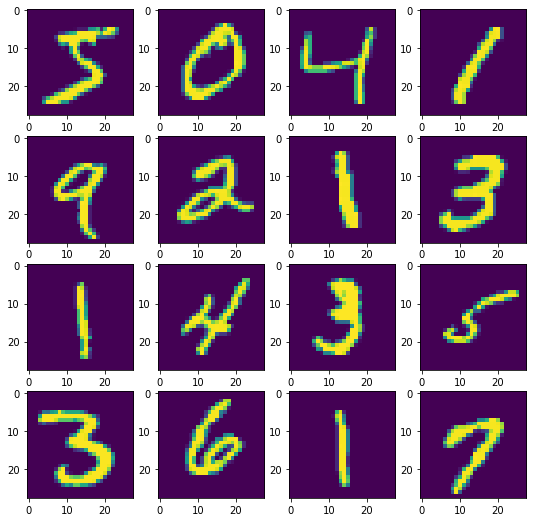

In [20]:
plt.figure(figsize = (9,9))
img_idx = 0
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[img_idx])
    img_idx +=1
plt.show()

In [22]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps*6*6
caps1_n_dims = 8
caps2_n_caps = 10
caps2_n_dims = 16

In [23]:
conv1_params = {
    "strides": 1,
    "filters": 256,
    "padding":"VALID",
    "activation": "relu",
    "kernel_size": 9
}
conv2_params = {
    "strides": 2,
    "kernel_size":9,
    "filters": caps1_n_maps*caps1_n_dims,
    "padding":"VALID",
    "activation": "relu"
}

In [21]:
X = tf.compat.v1.placeholder(shape = (None,28,28,1),dtype =tf.float32)

In [24]:
conv1_layer = tf.compat.v1.layers.conv2d(X,**conv1_params)
conv2_layer = tf.compat.v1.layers.conv2d(conv1_layer,**conv2_params)
conv2_reshaped = tf.reshape(conv2_layer,shape= (-1,caps1_n_caps,caps1_n_dims))

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [27]:
def squash(s,axis = -1,epsilon = 1e-9):
    with tf.compat.v1.name_scope("Squashing"):
        square = tf.reduce_sum(tf.square(s),axis = axis,keepdims = True)
        norm = tf.sqrt(square+epsilon)
        squashed = square/(1.+square)
        squashed = squashed/norm
        return s*squashed

In [28]:
caps1_output= squash(conv2_reshaped)

In [29]:
W_init = tf.compat.v1.random_normal(shape = (1,caps1_n_caps,caps2_n_caps,caps2_n_dims,caps1_n_dims))
W = tf.Variable(W_init,name = "WeightMatrix")
batch_shape = tf.shape(X)[0]
W_tiled = tf.tile(W,[batch_shape,1,1,1,1],name = "W_tiled")

print(W_tiled)

caps1_output_exp = tf.expand_dims(caps1_output,axis = -1)
caps1_output_exp = tf.expand_dims(caps1_output_exp,axis = 2)
caps1_output_ = tf.tile(caps1_output_exp,[1,1,caps2_n_caps,1,1])

print(caps1_output_)

caps_predicted = tf.matmul(W_tiled,caps1_output_)

print(caps_predicted)

Tensor("W_tiled:0", shape=(None, 1152, 10, 16, 8), dtype=float32)
Tensor("Tile:0", shape=(None, 1152, 10, 8, 1), dtype=float32)
Tensor("MatMul:0", shape=(None, 1152, 10, 16, 1), dtype=float32)


#Routing By Agreement Implementation

In [30]:
b_j = tf.zeros(shape =[tf.shape(X)[0],caps1_n_caps,caps2_n_caps,1,1],dtype = tf.float32)
c_j = tf.nn.softmax(b_j,axis = 2)

In [46]:
weighted_prediction = tf.multiply(c_j,caps_predicted)
print(weighted_prediction)
weighted_sum = tf.reduce_sum(weighted_prediction,axis = 1,keepdims = True)
print(weighted_sum)
caps2_output_round_1 = squash(weighted_sum,axis = -2)
print(caps2_output_round_1)

Tensor("Mul_5:0", shape=(None, 1152, 10, 16, 1), dtype=float32)
Tensor("Sum_3:0", shape=(None, 1, 10, 16, 1), dtype=float32)
Tensor("Squashing_4/mul:0", shape=(None, 1, 10, 16, 1), dtype=float32)


# Round 2 of Dynamic Routing

In [32]:
caps2_output_round2 = tf.tile(caps2_output_round_1,[1,caps1_n_caps,1,1,1])
print(caps2_output_round2)
print(caps_predicted)
agreement = tf.matmul(caps_predicted,caps2_output_round2,transpose_a = True)
print(agreement)

Tensor("Tile_1:0", shape=(None, 1152, 10, 16, 1), dtype=float32)
Tensor("MatMul:0", shape=(None, 1152, 10, 16, 1), dtype=float32)
Tensor("MatMul_1:0", shape=(None, 1152, 10, 1, 1), dtype=float32)


In [33]:
raw_weight_round_2 = tf.add(agreement,b_j)
softmax_round_2_b_j = tf.nn.softmax(raw_weight_round_2,axis = 2)
predicted_output_round2 = tf.multiply(softmax_round_2_b_j,caps_predicted)
print(predicted_output_round2)
predicted_sum_round2 = tf.reduce_sum(predicted_output_round2,axis = 1 ,keepdims = True)
print(predicted_sum_round2)
predicted_squashed_round2 =  squash(predicted_sum_round2,axis = -2)
print(predicted_sum_round2)
caps2_output = predicted_squashed_round2

Tensor("Mul_1:0", shape=(None, 1152, 10, 16, 1), dtype=float32)
Tensor("Sum_1:0", shape=(None, 1, 10, 16, 1), dtype=float32)
Tensor("Sum_1:0", shape=(None, 1, 10, 16, 1), dtype=float32)


In [34]:
def safe_norm(s, axis=-1, epsilon=1e-9, keep_dims=False, name=None):
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [35]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

In [36]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

In [37]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
y_pred

<tf.Tensor 'y_pred:0' shape=(None,) dtype=int64>

In [38]:
y = tf.compat.v1.placeholder(shape=[None], dtype=tf.int64, name="y")

In [39]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

In [40]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

In [44]:
alpha = 0.0005
loss = margin_loss
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")


optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001)
training_op = optimizer.minimize(loss, name="training_op")

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [45]:
n_epochs = 10
batch_size = 128
restore_checkpoint = True

n_iterations_per_epoch = x_train.shape[0]//batch_size
n_iterations_validation = x_val.shape[0]//batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.compat.v1.Session() as sess:
    if restore_checkpoint and tf.compat.v1.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch):
            X_batch, y_batch = x_train[iteration*batch_size:(iteration+1)*batch_size],y_train[iteration*batch_size:(iteration+1)*batch_size]
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = x_val[iteration*batch_size:(iteration+1)*batch_size],y_val[iteration*batch_size:(iteration+1)*batch_size]
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 98.1571%  Loss: 0.035211 (improved)
Epoch: 2  Val accuracy: 98.7380%  Loss: 0.023332 (improved)
Epoch: 3  Val accuracy: 98.9383%  Loss: 0.018704 (improved)
Epoch: 4  Val accuracy: 99.0385%  Loss: 0.015608 (improved)
Epoch: 5  Val accuracy: 99.0986%  Loss: 0.014120 (improved)
Epoch: 6  Val accuracy: 99.0385%  Loss: 0.014714
Epoch: 7  Val accuracy: 99.0785%  Loss: 0.013020 (improved)
Epoch: 8  Val accuracy: 99.1386%  Loss: 0.012062 (improved)
Epoch: 9  Val accuracy: 99.1587%  Loss: 0.011766 (improved)
Epoch: 10  Val accuracy: 99.2188%  Loss: 0.011878
